# Task 1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "./Electricity Consumption.csv"  # Replace with your file path
data = pd.read_csv(file_path)
print (data.head())
postalcode_data = pd.read_csv('./Postal Codes - Lleida.csv')
postalcode = postalcode_data['CODPOS']

   postalcode                           time  contracts  consumption
0       25001  2021-06-30 23:00:00.000000000      16128         4085
1       25002  2021-06-30 23:00:00.000000000       5647         1349
2       25003  2021-06-30 23:00:00.000000000      11439         2473
3       25004  2021-06-30 23:00:00.000000000       3892          887
4       25005  2021-06-30 23:00:00.000000000      14447         3298


In [ ]:
import zipfile
with zipfile.ZipFile("/content/Spain_shapefile.zip","r") as zip_ref:
    zip_ref.extractall("./Spain_shapefile")
# !zip -r  ./

In [ ]:

# Convert time to datetime and extract date and hour
data['time'] = pd.to_datetime(data['time'])
data['date'] = data['time'].dt.date
data['hour'] = data['time'].dt.hour
print (data.head())

   postalcode                time  contracts  consumption        date  hour
0       25001 2021-06-30 23:00:00      16128         4085  2021-06-30    23
1       25002 2021-06-30 23:00:00       5647         1349  2021-06-30    23
2       25003 2021-06-30 23:00:00      11439         2473  2021-06-30    23
3       25004 2021-06-30 23:00:00       3892          887  2021-06-30    23
4       25005 2021-06-30 23:00:00      14447         3298  2021-06-30    23


In [ ]:

# Pivot to create a matrix of hourly consumption per day per postal code
pivot_data = data.pivot_table(index=['postalcode', 'date'], columns='hour', values='consumption', aggfunc='sum', fill_value=0)
print (pivot_data.head())

hour                     0     1     2     3     4     5     6     7     8   \
postalcode date                                                               
25001      2021-06-30     0     0     0     0     0     0     0     0     0   
           2021-07-01  3391  2895  2663  2578  2614  2994  3552  3799  3860   
           2021-07-02  3519  3026  2755  2697  2718  3059  3756  3981  4038   
           2021-07-03  3699  3173  2906  2762  2727  2820  3159  3771  4415   
           2021-07-04  3669  3189  2900  2765  2680  2670  2858  3442  4169   

hour                     9   ...    14    15    16    17    18    19    20  \
postalcode date              ...                                             
25001      2021-06-30     0  ...     0     0     0     0     0     0     0   
           2021-07-01  4046  ...  5827  5670  5520  5558  5678  6098  6474   
           2021-07-02  4275  ...  6384  6224  6110  6280  6231  6293  6440   
           2021-07-03  4761  ...  6390  6205  6144  6123

In [ ]:
# postalcode_grouped = pivot_data.groupby('postalcode').mean()
# print (postalcode_grouped.head())
features_scaled = pivot_data.div(pivot_data.sum(axis=1), axis=0)
# print (features_scaled.head())

In [ ]:
# Determine the optimal number of clusters using silhouette scores
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

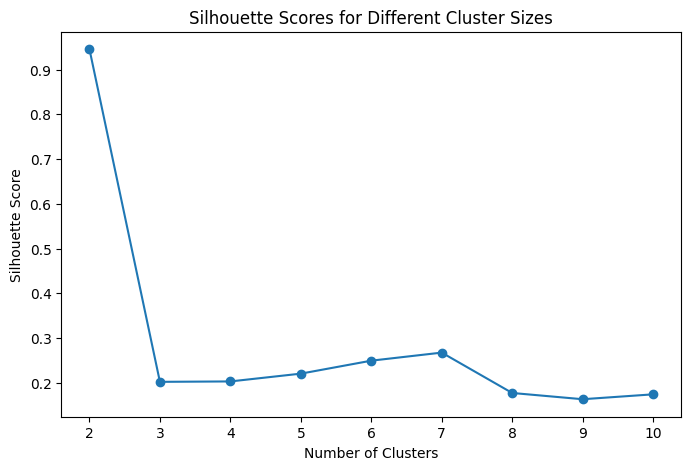

In [ ]:

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Cluster Sizes")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()



In [ ]:

# Choose the optimal number of clusters and fit KMeans
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the data
pivot_data['cluster'] = cluster_labels
pivot_data.to_csv('postalcode_clusters.csv', index=True)


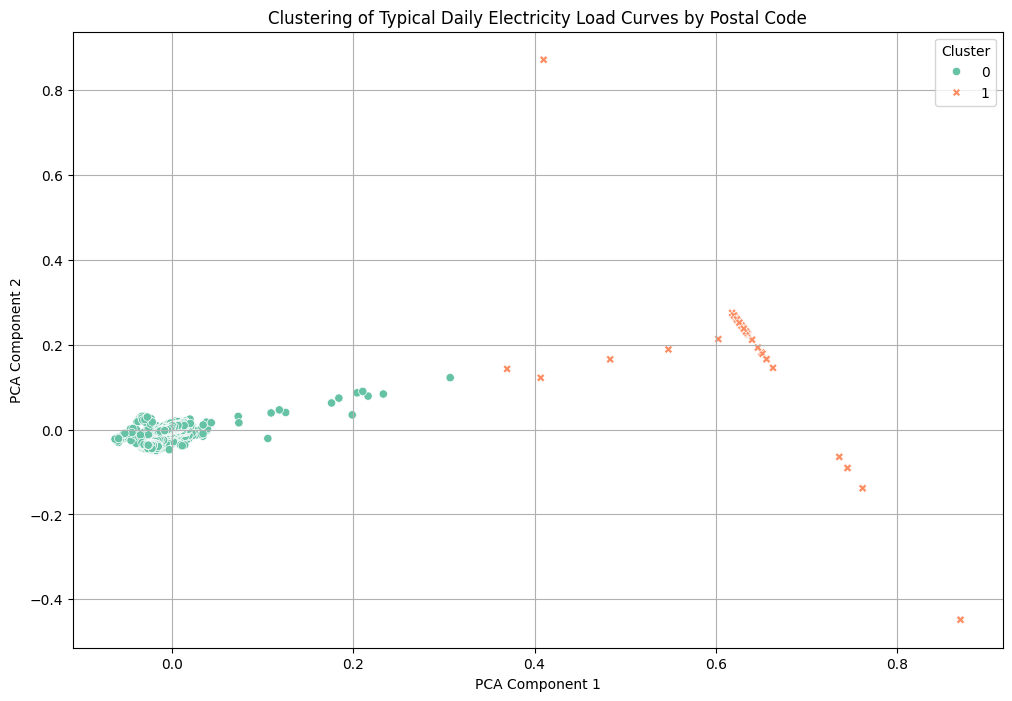

Cluster Centroids (Typical Daily Patterns):
hour        0         1         2         3         4         5         6   \
0     0.034638  0.029343  0.029987  0.029114  0.029373  0.031480  0.036203   
1     0.000448  0.000786  0.000605  0.000795  0.000362  0.000557  0.000592   

hour        7         8         9   ...        14        15        16  \
0     0.040348  0.041849  0.042219  ...  0.046033  0.043996  0.043410   
1     0.000595  0.001017  0.000866  ...  0.000623  0.000837  0.000777   

hour        17        18        19        20        21        22        23  
0     0.044844  0.048567  0.053792  0.056776  0.052979  0.042972  0.039622  
1     0.001090  0.000432  0.001233  0.000536  0.000790  0.341758  0.642133  

[2 rows x 24 columns]


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Add PCA components for visualization
pivot_data['pca1'] = features_pca[:, 0]
pivot_data['pca2'] = features_pca[:, 1]

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='cluster',
    palette='Set2',
    data=pivot_data,
    style='cluster'
)
plt.title('Clustering of Typical Daily Electricity Load Curves by Postal Code')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Analyze the cluster centroids to identify common patterns
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=features_scaled.columns)
print("Cluster Centroids (Typical Daily Patterns):")
print(centroid_df)


# Task 2

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer
from geopy.geocoders import Nominatim

# Define the UTM coordinate system (EPSG: 25830) and the geographic coordinate system (EPSG: 4326)
utm_proj = "epsg:25830"  # UTM zone 30N (Spain)
latlon_proj = "epsg:4326"  # WGS84 (lat/lon)
transformer = Transformer.from_crs(utm_proj, latlon_proj, always_xy=True)

# Load cadaster data
cadaster_data = pd.read_csv("./Cadaster Lleida.csv")

# Create a GeoDataFrame from cadaster coordinates
geometry = [Point(*transformer.transform(x, y)) for x, y in zip(cadaster_data['X'], cadaster_data['Y'])]
cadaster_gdf = gpd.GeoDataFrame(cadaster_data, geometry=geometry, crs="EPSG:4326")

# Load postal code boundaries (shapefile or GeoJSON)
postal_code_boundaries = gpd.read_file("es_1km.shp")  # Replace with your file path

# Ensure both datasets are in the same coordinate reference system (CRS)
postal_code_boundaries = postal_code_boundaries.to_crs(cadaster_gdf.crs)

# Perform spatial join to assign postal codes to cadaster data
cadaster_with_postal_codes = gpd.sjoin(
    cadaster_gdf,
    postal_code_boundaries,
    how="left",
    predicate="intersects"  # Explicit predicate required in modern GeoPandas
)

# Save or use the resulting GeoDataFrame
cadaster_with_postal_codes.to_csv("cadaster_with_postal_codes.csv", index=False)

# Print the resulting GeoDataFrame
print(cadaster_with_postal_codes)


                   X             Y                     gml_id  \
0      295065.839553  4.614636e+06  ES.SDGC.BU.000100100BG91D   
1      295076.878115  4.614653e+06  ES.SDGC.BU.000100100BG91D   
2      295089.967500  4.614675e+06  ES.SDGC.BU.000100100BG91D   
3      295100.218801  4.614658e+06  ES.SDGC.BU.000100100BG91D   
4      299990.745139  4.612235e+06  ES.SDGC.BU.000100100CG01A   
...              ...           ...                        ...   
18119  289934.103564  4.616932e+06  ES.SDGC.BU.9971508BG8197B   
18120  289842.892309  4.616977e+06  ES.SDGC.BU.9971903BG8197B   
18121  289865.696385  4.616958e+06  ES.SDGC.BU.9971905BG8197B   
18122  289872.672738  4.616945e+06  ES.SDGC.BU.9971906BG8197B   
18123  289883.975810  4.616935e+06  ES.SDGC.BU.9971907BG8197B   

      beginLifespanVersion conditionOfConstruction            beginning  \
0      2012-11-06T00:00:00              functional  1990-01-01T00:00:00   
1      2012-11-06T00:00:00              functional  1990-01-01T00:00:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load datasets
electricity_data = pd.read_csv("./Electricity Consumption.csv")
cluster_data = pd.read_csv("./postalcode_clusters.csv")  # Cluster labels from previous task
weather_data = pd.read_csv("./Weather.csv")  # Weather: temp, humidity, wind, etc.
# cadaster_data = pd.read_csv("cadaster_data.csv")  # Property density, building types, etc.
socio_economic_data = pd.read_csv("./Socio-Economic.csv")  # Income, population, etc.


In [ ]:
postalcode_data = pd.read_csv('./Postal Codes - Lleida.csv')
postalcode = postalcode_data['CODPOS']

In [ ]:

# Preprocess electricity data
electricity_data['time'] = pd.to_datetime(electricity_data['time'])
electricity_data['date'] = electricity_data['time'].dt.date

# Aggregate daily consumption
daily_consumption = electricity_data.groupby(['postalcode', 'date'])['consumption'].sum().reset_index()
daily_consumption = daily_consumption.rename(columns={'consumption': 'daily_consumption'})

# Merge weather data (by postal code and date)
weather_data['time'] = pd.to_datetime(weather_data['time'])
weather_data['date'] = weather_data['time'].dt.date
data = daily_consumption.merge(weather_data, on=['postalcode', 'date'], how='left')

data = data.merge(cluster_data, on=['postalcode', 'date'], how='right')

# Extract year from the date column for the merge
data['year'] = pd.to_datetime(data['date']).dt.year

# Merge cadastral and socio-economic data (by postal code)
# data = data.merge(cadaster_data, on='postalcode', how='left')
data = data.merge(socio_economic_data, on=['postalcode', 'year'], how='left')

# Add lagged features (e.g., previous day's consumption)
data['prev_day_consumption'] = data.groupby('postalcode')['daily_consumption'].shift(1)


# Drop rows with missing values
data.dropna(axis = 0)

for code in postalcode:
    print (code)
    # Prepare features and target
    features = ['prev_day_consumption', 'airtemperature', 'relativehumidity', 'windspeed',
                'population', 'peopleperhousehold']  # Add relevant features
    data_new = data[data['postalcode'] == code].copy()
    # print (data_new)
    X = data_new[features]
    y = data_new['cluster']
    # print (y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train a Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)

    # Make predictions and calculate probabilities
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)

    # Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    logloss = log_loss(y_test, y_prob)
    print(f"Log Loss: {logloss}")

    # Forecast probabilities for the next day
    next_day_features = X_test[:1]  # Replace with actual next day's features
    next_day_probabilities = rf.predict_proba(next_day_features)

    print("Next Day Cluster Probabilities:")
    print(next_day_probabilities)


25001
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       237
           1       0.00      0.00      0.00         1

    accuracy                           1.00       238
   macro avg       0.50      0.50      0.50       238
weighted avg       0.99      1.00      0.99       238

Log Loss: 0.5195188134629477
Next Day Cluster Probabilities:
[[0.59577692 0.40422308]]
25004
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       237
           1       0.00      0.00      0.00         1

    accuracy                           1.00       238
   macro avg       0.50      0.50      0.50       238
weighted avg       0.99      1.00      0.99       238

Log Loss: 0.5195188134629477
Next Day Cluster Probabilities:
[[0.59577692 0.40422308]]
25005
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1

# Task 3

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load and merge datasets (electricity consumption, weather, cadaster, socio-economic)
consumption_data = pd.read_csv("./Electricity Consumption.csv")
weather_data = pd.read_csv("./Weather.csv")
# cadaster_data = pd.read_csv("cadaster_with_postal_codes.csv")
socio_economic_data = pd.read_csv("./Socio-Economic.csv")



In [14]:
postalcode_data = pd.read_csv('./Postal Codes - Lleida.csv')
postalcode = postalcode_data['CODPOS']

In [15]:
# Merge data on common keys like postal codes and timestamps
merged_data = consumption_data.merge(weather_data, on=["postalcode", "time"], how="left")
# merged_data = merged_data.merge(cadaster_data, on="postalcode", how="left")
merged_data = merged_data.merge(socio_economic_data, on="postalcode", how="left")

# Preprocess data
merged_data["time"] = pd.to_datetime(merged_data["time"])
merged_data.set_index("time", inplace=True)
merged_data.sort_index(inplace=True)
merged_data = merged_data.dropna()
# Fill missing values
merged_data.ffill()

,postalcode,contracts,consumption,airtemperature,relativehumidity,ghi,sunelevation,sunazimuth,highvegetationratio,lowvegetationratio,...,netincomesperperson,incomessourceisotherbenefits,incomessourceisotherincomes,incomessourceispension,incomessourceisunemploymentbenefit,incomessourceissalary,giniindex,incomesratioq80byq20,averagepopulationage,peopleperhousehold
time,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00,25001,16128,3391,20.417629,82.681901,0.0,-24.950263,7.290889,2.035670,1.452567,...,11429,538,1297,2516,302,8985,31,2,40,2
2021-07-01 00:00:00,25001,16128,3391,20.417629,82.681901,0.0,-24.950263,7.290889,2.035670,1.452567,...,11788,575,1306,2600,258,9353,31,2,40,2
2021-07-01 00:00:00,25001,16128,3391,20.417629,82.681901,0.0,-24.950263,7.290889,2.035670,1.452567,...,12238,596,1341,2693,233,9829,30,2,41,2
2021-07-01 00:00:00,25001,16128,3391,20.417629,82.681901,0.0,-24.950263,7.290889,2.035670,1.452567,...,12647,693,1452,2793,230,10039,29,2,41,2
2021-07-01 00:00:00,25001,16128,3391,20.417629,82.681901,0.0,-24.950263,7.290889,2.035670,1.452567,...,13330,715,1481,2991,242,10650,29,2,41,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30 22:00:00,25199,1672,32,16.267355,83.325060,0.0,-47.919177,330.477724,2.422351,1.306970,...,17948,901,4081,4631,469,12689,32,2,46,2
2024-09-30 22:00:00,25199,1672,32,16.267355,83.325060,0.0,-47.919177,330.477724,2.422351,1.306970,...,18024,900,5108,4645,295,13558,33,2,46,2
2024-09-30 22:00:00,25199,1672,32,16.267355,83.325060,0.0,-47.919177,330.477724,2.422351,1.306970,...,18024,900,5108,4645,295,13558,33,2,46,2


Processing postal code: 25001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 3.1215 - mae: 0.7901 - val_loss: 2.5245 - val_mae: 0.7884 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 2.1302 - mae: 0.6119 - val_loss: 1.7749 - val_mae: 0.6193 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 1.4562 - mae: 0.4530 - val_loss: 1.2677 - val_mae: 0.4984 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - loss: 1.0239 - mae: 0.3544 - val_loss: 0.9942 - val_mae: 0.4634 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.7402 - mae: 0.3018 - val_loss: 0.7941 - val_mae: 0.4360 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.5592 - mae: 0.2779 - val_loss: 0.6662 - val_mae: 0.4237 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.4576 - mae: 0.2886 - val_loss: 0.6261 - val_mae: 0.4673 - learning_rate: 0.0010
Epoch 8/2

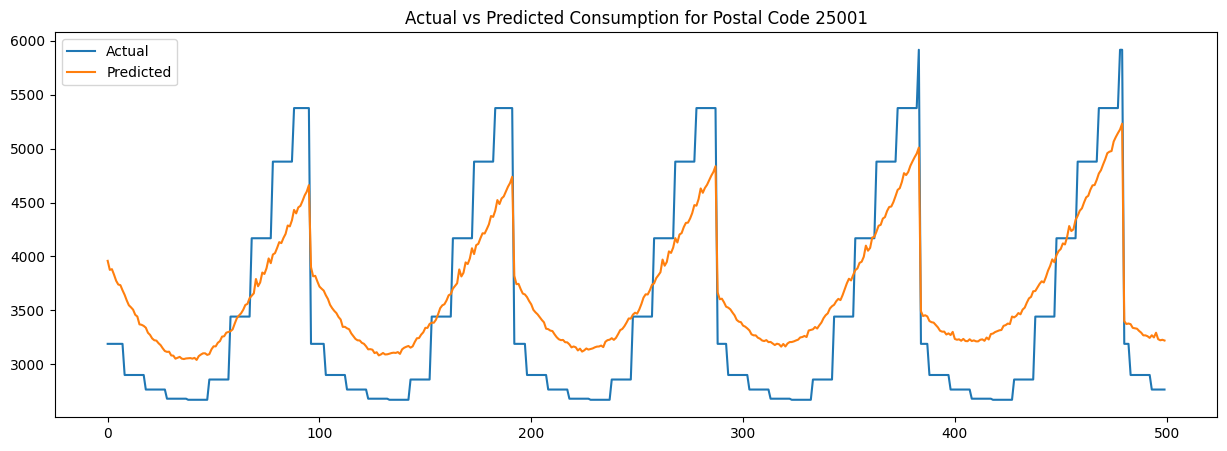

Processing postal code: 25002
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 3.1184 - mae: 0.7941 - val_loss: 2.5500 - val_mae: 0.7984 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 2.1881 - mae: 0.6578 - val_loss: 1.7742 - val_mae: 0.6253 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 1.5002 - mae: 0.5006 - val_loss: 1.3140 - val_mae: 0.5214 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 1.0656 - mae: 0.3931 - val_loss: 1.0997 - val_mae: 0.5146 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - loss: 0.7639 - mae: 0.3069 - val_loss: 0.8687 - val_mae: 0.4818 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.5668 - mae: 0.2723 - val_loss: 0.7396 - val_mae: 0.4541 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.4587 - mae: 0.2701 - val_loss: 0.6127 - val_mae: 0.4409 - learning_rate: 0.0010
Epoch 8/20
18/18 ━━━━

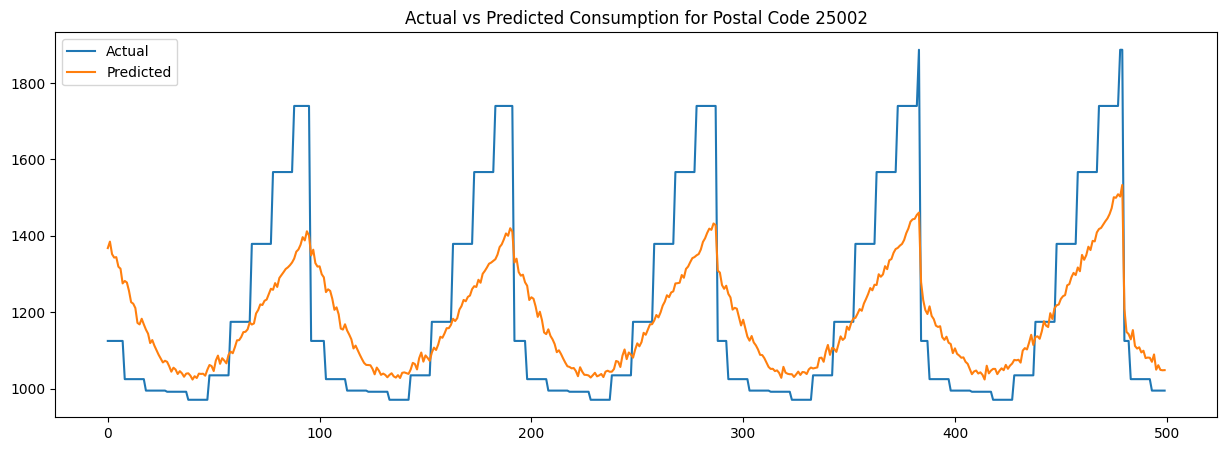

Processing postal code: 25003
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 2.9142 - mae: 0.6786 - val_loss: 2.5409 - val_mae: 0.8268 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 2.0281 - mae: 0.5619 - val_loss: 1.8098 - val_mae: 0.7184 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 1.3903 - mae: 0.4491 - val_loss: 1.3026 - val_mae: 0.6062 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 0.9656 - mae: 0.3612 - val_loss: 1.0354 - val_mae: 0.5517 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.6979 - mae: 0.3138 - val_loss: 0.8336 - val_mae: 0.5417 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.5237 - mae: 0.3013 - val_loss: 0.7634 - val_mae: 0.5618 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.4123 - mae: 0.2903 - val_loss: 0.6999 - val_mae: 0.5668 - learning_rate: 0.0010
Epoch 8/20
18/18 

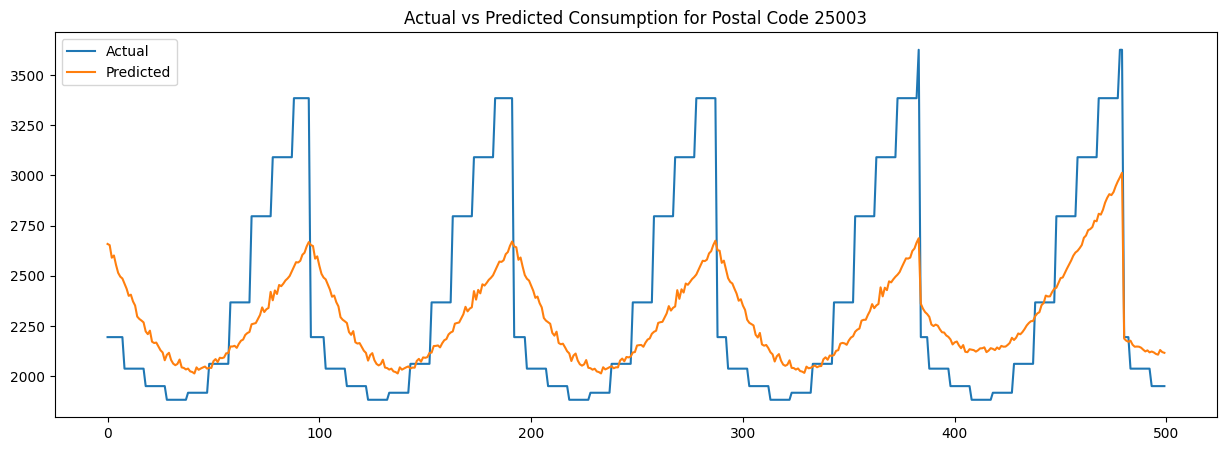

Processing postal code: 25004
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 3.0417 - mae: 0.7253 - val_loss: 2.5177 - val_mae: 0.7840 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 2.0588 - mae: 0.5523 - val_loss: 1.7513 - val_mae: 0.6154 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 1.4155 - mae: 0.4262 - val_loss: 1.3592 - val_mae: 0.5566 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.9969 - mae: 0.3429 - val_loss: 1.0689 - val_mae: 0.5222 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.7542 - mae: 0.3338 - val_loss: 0.8809 - val_mae: 0.5292 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.5746 - mae: 0.3142 - val_loss: 0.7899 - val_mae: 0.5160 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.4693 - mae: 0.3135 - val_loss: 0.7368 - val_mae: 0.5335 - learning_rate: 0.0010
Epoch 8/20
18/18 ━━━

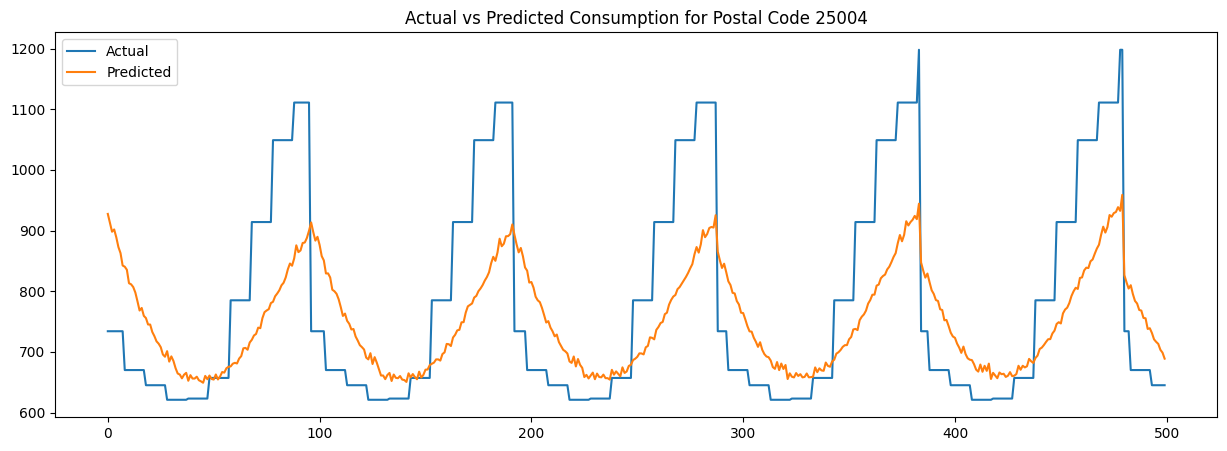

Processing postal code: 25005
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 3.1000 - mae: 0.7813 - val_loss: 2.5549 - val_mae: 0.7955 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 2.1349 - mae: 0.6167 - val_loss: 1.7410 - val_mae: 0.6160 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.4372 - mae: 0.4482 - val_loss: 1.2864 - val_mae: 0.5159 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 1.0088 - mae: 0.3573 - val_loss: 0.9563 - val_mae: 0.4416 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.7773 - mae: 0.3370 - val_loss: 0.8375 - val_mae: 0.4811 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.5790 - mae: 0.3084 - val_loss: 0.7368 - val_mae: 0.4723 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.4413 - mae: 0.2681 - val_loss: 0.6961 - val_mae: 0.4933 - learning_rate: 0.0010
Epoch 8/20
18/18 ━━━━

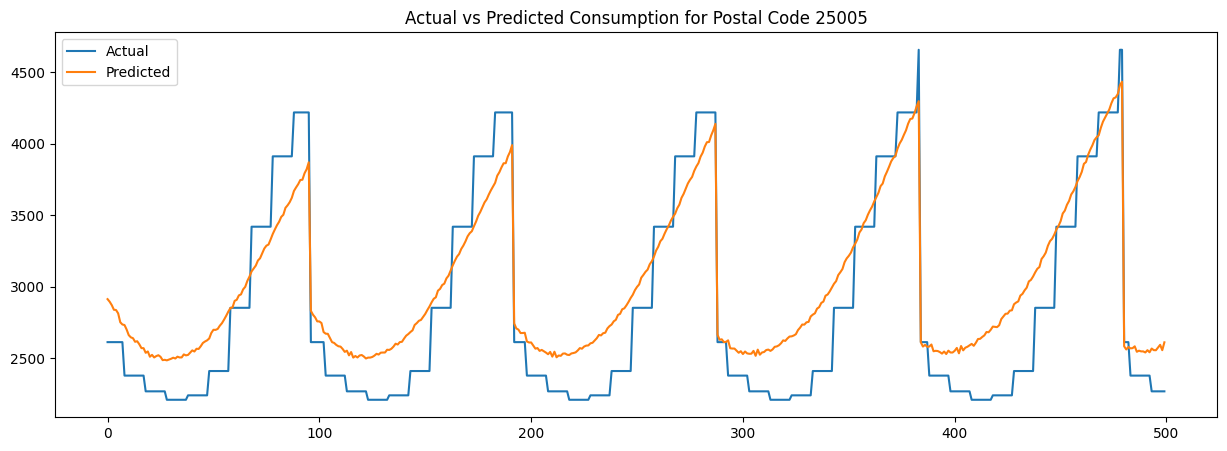

Processing postal code: 25006
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 3.1488 - mae: 0.7769 - val_loss: 2.4984 - val_mae: 0.7549 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 2.1323 - mae: 0.5892 - val_loss: 1.7115 - val_mae: 0.5642 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 1.4473 - mae: 0.4368 - val_loss: 1.2868 - val_mae: 0.4897 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 1.0199 - mae: 0.3473 - val_loss: 1.0598 - val_mae: 0.4947 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.7510 - mae: 0.3165 - val_loss: 0.8441 - val_mae: 0.4708 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.5633 - mae: 0.2875 - val_loss: 0.6929 - val_mae: 0.4516 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.4484 - mae: 0.2826 - val_loss: 0.6395 - val_mae: 0.4589 - learning_rate: 0.0010
Epoch 8/20
18/18 ━━━━

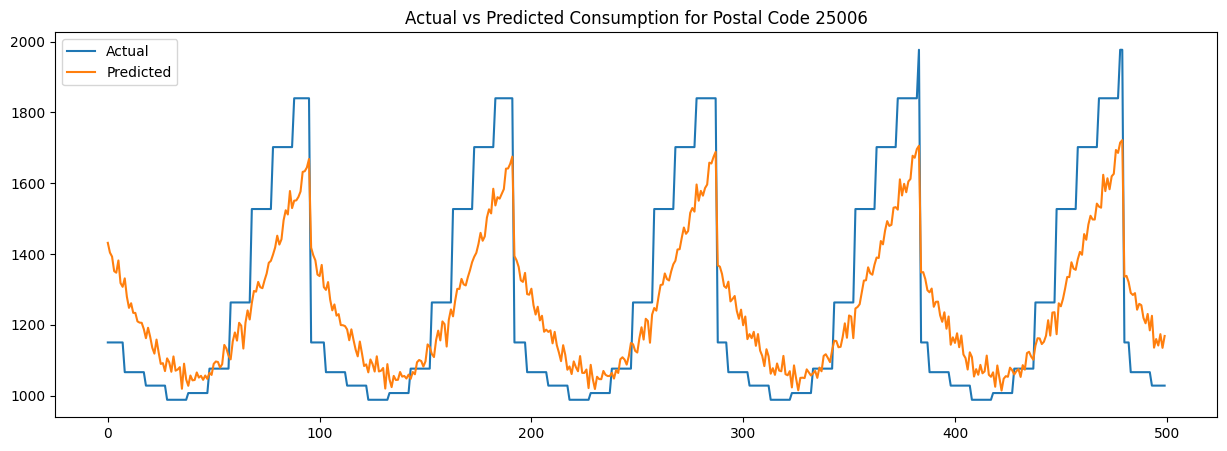

Processing postal code: 25007
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 3.1598 - mae: 0.8109 - val_loss: 2.5613 - val_mae: 0.7939 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 2.2116 - mae: 0.6660 - val_loss: 1.7704 - val_mae: 0.6013 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 1.5041 - mae: 0.4858 - val_loss: 1.2656 - val_mae: 0.4690 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 1.0592 - mae: 0.3709 - val_loss: 0.9717 - val_mae: 0.4152 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 0.7818 - mae: 0.3182 - val_loss: 0.9492 - val_mae: 0.5127 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.6289 - mae: 0.3126 - val_loss: 0.7856 - val_mae: 0.4892 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.4636 - mae: 0.2601 - val_loss: 0.7270 - val_mae: 0.4977 - learning_rate: 0.0010
Epoch 8/20
18/18 

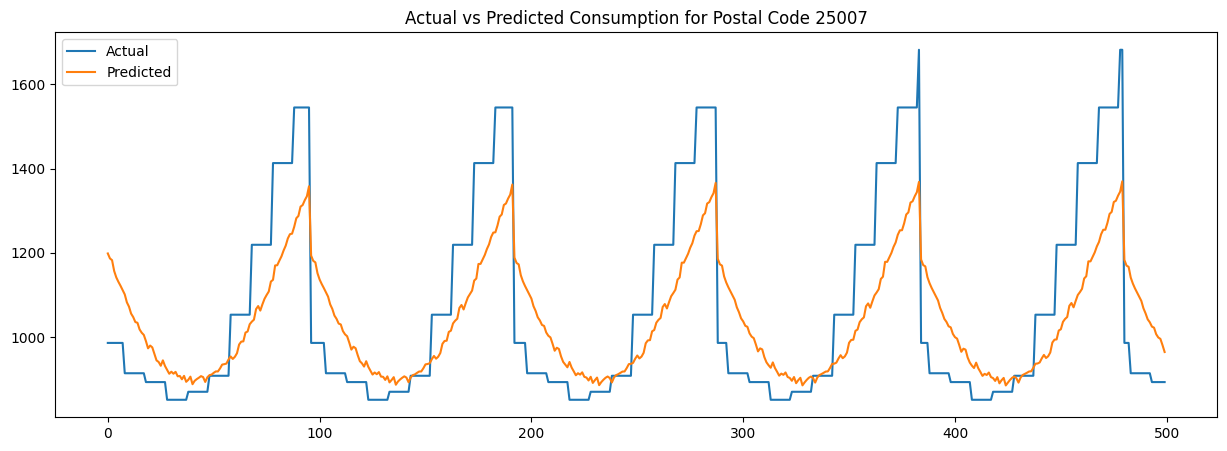

Processing postal code: 25008
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 3.1055 - mae: 0.7878 - val_loss: 2.5840 - val_mae: 0.8284 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 2.1659 - mae: 0.6459 - val_loss: 1.7677 - val_mae: 0.6374 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - loss: 1.4498 - mae: 0.4697 - val_loss: 1.3106 - val_mae: 0.5312 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.9866 - mae: 0.3393 - val_loss: 1.1183 - val_mae: 0.5318 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.7663 - mae: 0.3434 - val_loss: 0.8888 - val_mae: 0.4987 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.5676 - mae: 0.3041 - val_loss: 0.7498 - val_mae: 0.4858 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.4258 - mae: 0.2621 - val_loss: 0.6455 - val_mae: 0.4653 - learning_rate: 0.0010
Epoch 8/20
18/18 ━

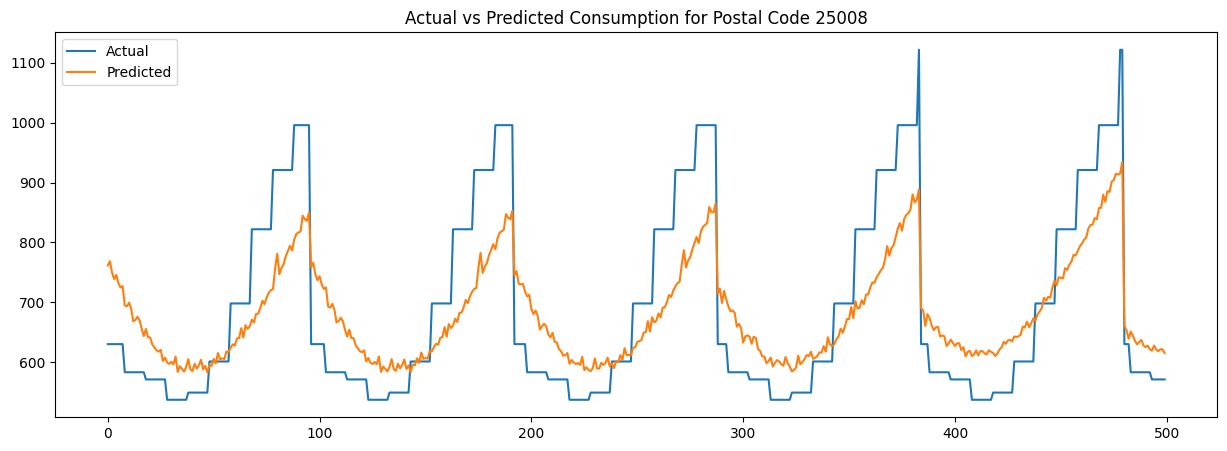

Processing postal code: 25110
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 3.0095 - mae: 0.7100 - val_loss: 2.6348 - val_mae: 0.8562 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 2.0992 - mae: 0.5954 - val_loss: 1.9155 - val_mae: 0.7427 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 1.4409 - mae: 0.4702 - val_loss: 1.4016 - val_mae: 0.6092 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 1.0229 - mae: 0.3863 - val_loss: 1.1751 - val_mae: 0.5958 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.7550 - mae: 0.3520 - val_loss: 0.9616 - val_mae: 0.5824 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.5987 - mae: 0.3594 - val_loss: 0.8408 - val_mae: 0.5695 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.4797 - mae: 0.3423 - val_loss: 0.7747 - val_mae: 0.5799 - learning_rate: 0.0010
Epoch 8/20
18/18 ━━━

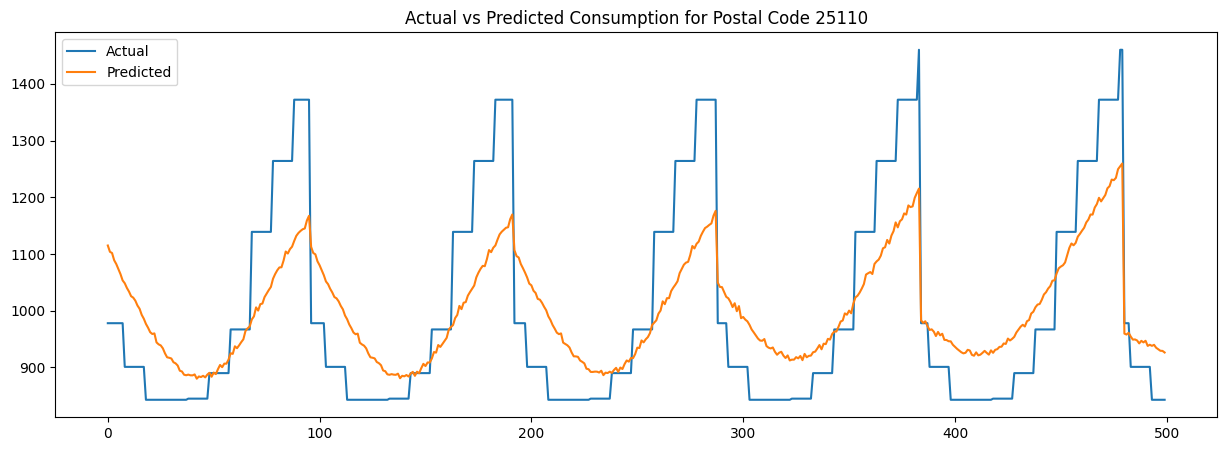

Processing postal code: 25111
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 3.0515 - mae: 0.6680 - val_loss: 2.8604 - val_mae: 0.9324 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 2.1591 - mae: 0.5877 - val_loss: 2.1114 - val_mae: 0.8148 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 1.5651 - mae: 0.5254 - val_loss: 1.8212 - val_mae: 0.7900 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - loss: 1.1252 - mae: 0.4547 - val_loss: 1.5068 - val_mae: 0.7645 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.8650 - mae: 0.4214 - val_loss: 1.2677 - val_mae: 0.7259 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.6820 - mae: 0.4064 - val_loss: 1.1682 - val_mae: 0.7324 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.5572 - mae: 0.3944 - val_loss: 1.1296 - val_mae: 0.7305 - learning_rate: 0.0010
Epoch 8/20
18/18 ━━━

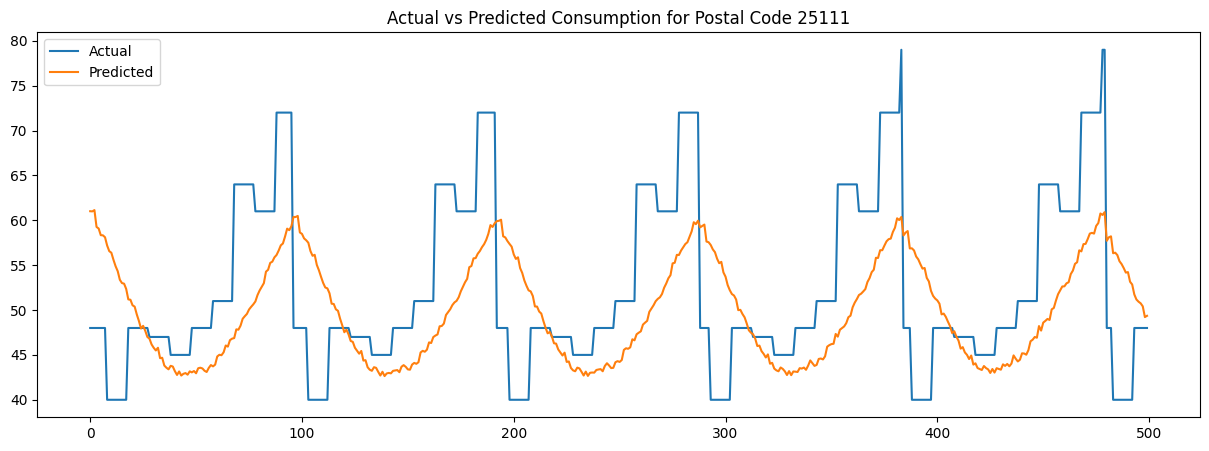

Processing postal code: 25113
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 2.9554 - mae: 0.6309 - val_loss: 2.4963 - val_mae: 0.7868 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 2.0781 - mae: 0.5603 - val_loss: 1.8294 - val_mae: 0.7081 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 1.4978 - mae: 0.5113 - val_loss: 1.4636 - val_mae: 0.6757 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 1.1244 - mae: 0.4803 - val_loss: 1.1409 - val_mae: 0.6499 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.8527 - mae: 0.4475 - val_loss: 1.0255 - val_mae: 0.6408 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.6847 - mae: 0.4391 - val_loss: 0.8498 - val_mae: 0.6315 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - loss: 0.5439 - mae: 0.4054 - val_loss: 0.7971 - val_mae: 0.6392 - learning_rate: 0.0010
Epoch 8/20
18/18 ━━━

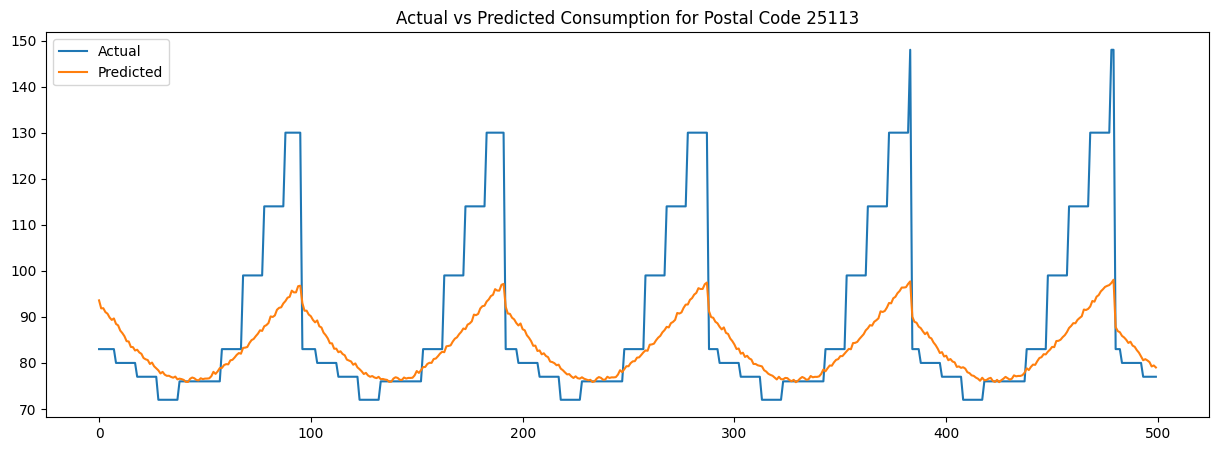

Processing postal code: 25191
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - loss: 3.5086 - mae: 0.8576 - val_loss: 2.4898 - val_mae: 0.7381 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 2.5402 - mae: 0.7843 - val_loss: 1.8885 - val_mae: 0.7237 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 1.8890 - mae: 0.7116 - val_loss: 1.6392 - val_mae: 0.7676 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 1.4928 - mae: 0.6685 - val_loss: 1.3315 - val_mae: 0.7390 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 1.1794 - mae: 0.6170 - val_loss: 1.3184 - val_mae: 0.7855 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 1.2434 - mae: 0.6996 - val_loss: 1.1257 - val_mae: 0.7672 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.9512 - mae: 0.6268 - val_loss: 0.9671 - val_mae: 0.7359 - learning_rate: 0.0010
Epoch 8/20
18/18 ━━

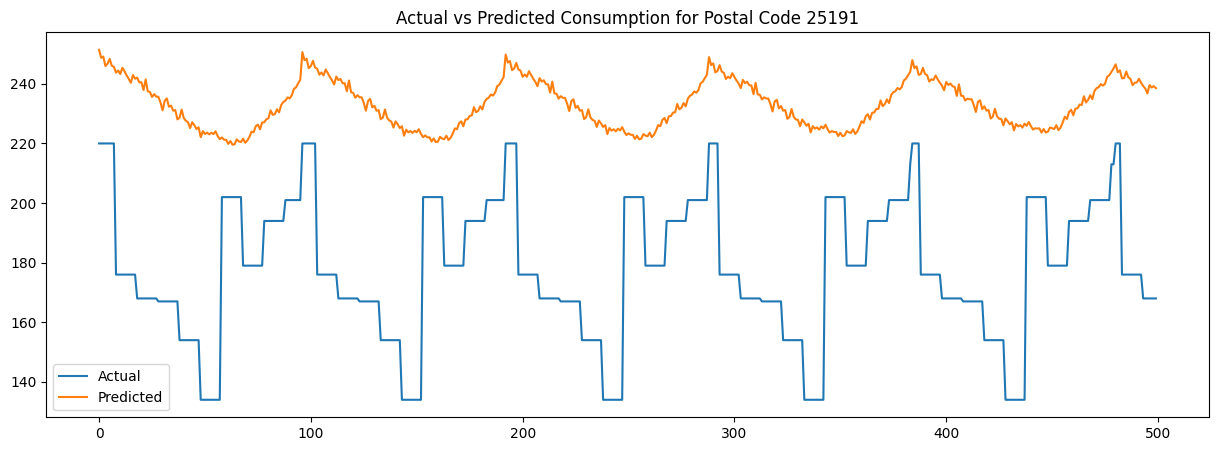

Processing postal code: 25192
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 3.0131 - mae: 0.6461 - val_loss: 3.1586 - val_mae: 0.9588 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 2.1151 - mae: 0.5616 - val_loss: 2.4407 - val_mae: 0.8710 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 1.4866 - mae: 0.4841 - val_loss: 1.8460 - val_mae: 0.7701 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 1.0687 - mae: 0.4390 - val_loss: 1.5876 - val_mae: 0.7642 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 0.8197 - mae: 0.4286 - val_loss: 1.3946 - val_mae: 0.7709 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.6483 - mae: 0.4181 - val_loss: 1.2714 - val_mae: 0.7218 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.5327 - mae: 0.4058 - val_loss: 1.1832 - val_mae: 0.7349 - learning_rate: 0.0010
Epoch 8/20
18/18 

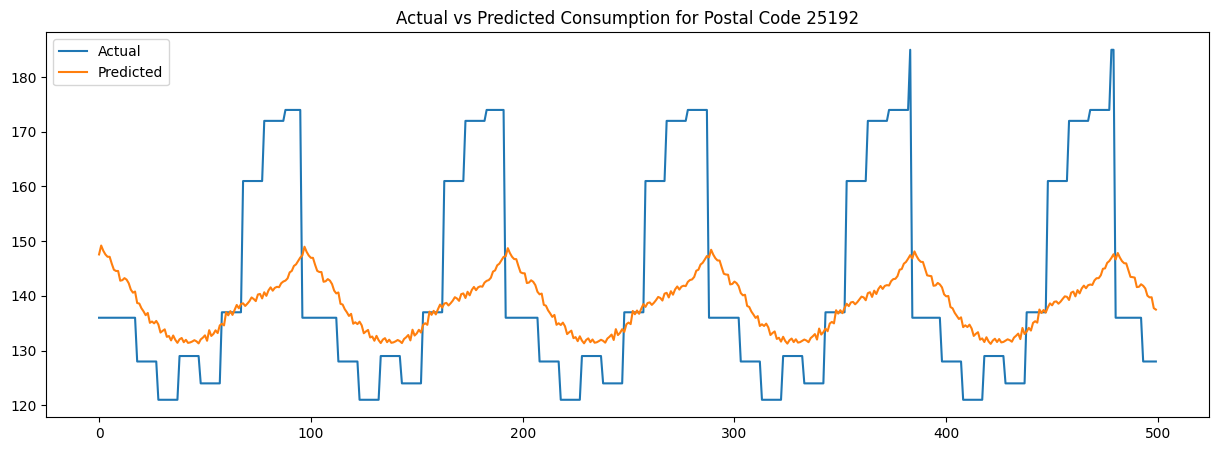

Processing postal code: 25193
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 3.0204 - mae: 0.6658 - val_loss: 2.4042 - val_mae: 0.6726 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 2.1238 - mae: 0.6062 - val_loss: 1.8679 - val_mae: 0.6753 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 1.5405 - mae: 0.5725 - val_loss: 1.5236 - val_mae: 0.6805 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 1.0971 - mae: 0.5031 - val_loss: 1.2878 - val_mae: 0.6819 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.8220 - mae: 0.4536 - val_loss: 1.1597 - val_mae: 0.7002 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.6529 - mae: 0.4350 - val_loss: 1.0784 - val_mae: 0.7049 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.5392 - mae: 0.4213 - val_loss: 0.9166 - val_mae: 0.6762 - learning_rate: 0.0010
Epoch 8/20
18/18 

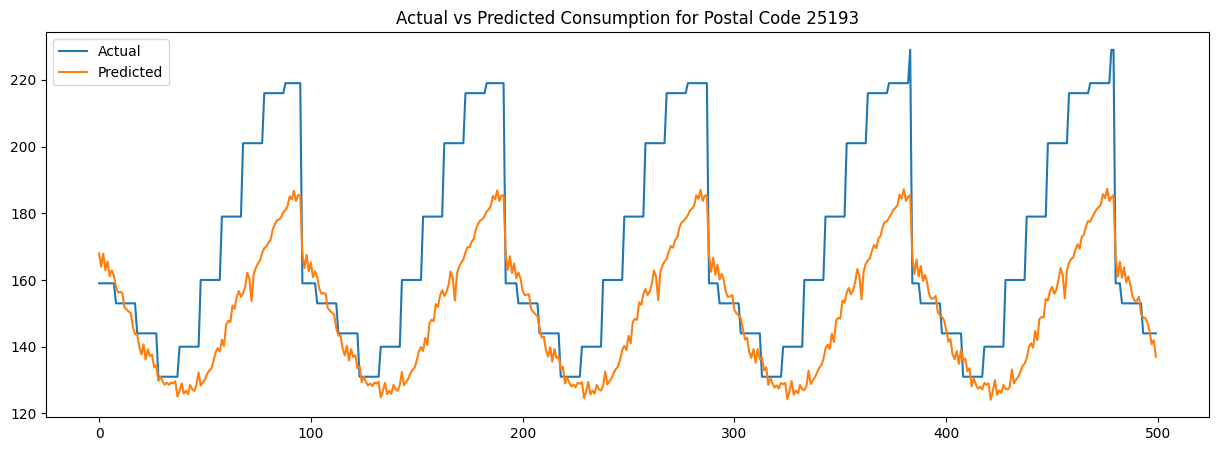

Processing postal code: 25194
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 3.0786 - mae: 0.7283 - val_loss: 2.7026 - val_mae: 0.8451 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 2.2253 - mae: 0.6730 - val_loss: 2.0335 - val_mae: 0.7892 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 1.6764 - mae: 0.6485 - val_loss: 1.6191 - val_mae: 0.7795 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 1.2802 - mae: 0.6199 - val_loss: 1.3120 - val_mae: 0.7519 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - loss: 1.0376 - mae: 0.6089 - val_loss: 1.1303 - val_mae: 0.7397 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.8865 - mae: 0.6062 - val_loss: 0.9996 - val_mae: 0.7179 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.7736 - mae: 0.5969 - val_loss: 0.9419 - val_mae: 0.7296 - learning_rate: 0.0010
Epoch 8/20
18/18 

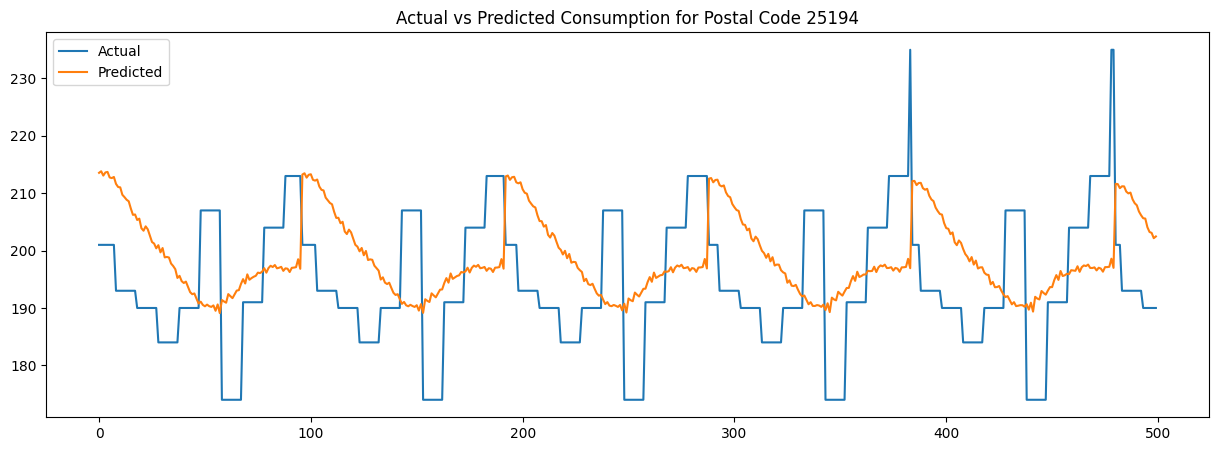

Processing postal code: 25195
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 3.0305 - mae: 0.7040 - val_loss: 2.7714 - val_mae: 0.9178 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 2.1165 - mae: 0.5931 - val_loss: 2.0329 - val_mae: 0.8056 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 1.4400 - mae: 0.4558 - val_loss: 1.4736 - val_mae: 0.6647 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 1.0371 - mae: 0.3826 - val_loss: 1.1749 - val_mae: 0.6340 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.7830 - mae: 0.3661 - val_loss: 0.9585 - val_mae: 0.6156 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.5904 - mae: 0.3359 - val_loss: 0.7901 - val_mae: 0.5762 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 0.4748 - mae: 0.3244 - val_loss: 0.7447 - val_mae: 0.5910 - learning_rate: 0.0010
Epoch 8/20
18/18 

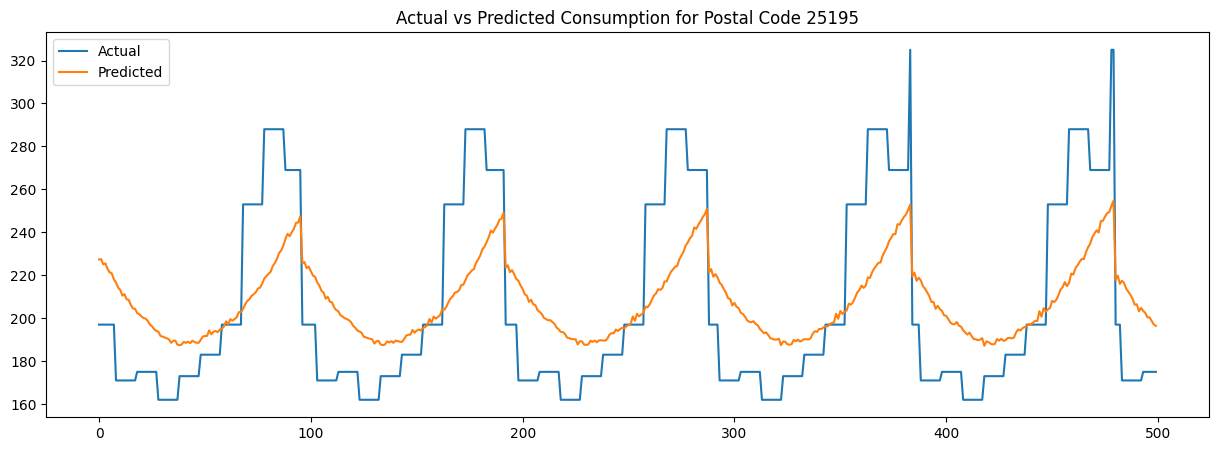

Processing postal code: 25196
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 3.0344 - mae: 0.7025 - val_loss: 2.6670 - val_mae: 0.8579 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 2.0942 - mae: 0.5800 - val_loss: 1.8499 - val_mae: 0.6989 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - loss: 1.4365 - mae: 0.4626 - val_loss: 1.4378 - val_mae: 0.6418 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 1.0298 - mae: 0.3969 - val_loss: 1.2473 - val_mae: 0.6480 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.7550 - mae: 0.3533 - val_loss: 0.9400 - val_mae: 0.5779 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.5683 - mae: 0.3249 - val_loss: 0.8494 - val_mae: 0.5866 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.4497 - mae: 0.3109 - val_loss: 0.8484 - val_mae: 0.6257 - learning_rate: 0.0010
Epoch 8/20
18/18 

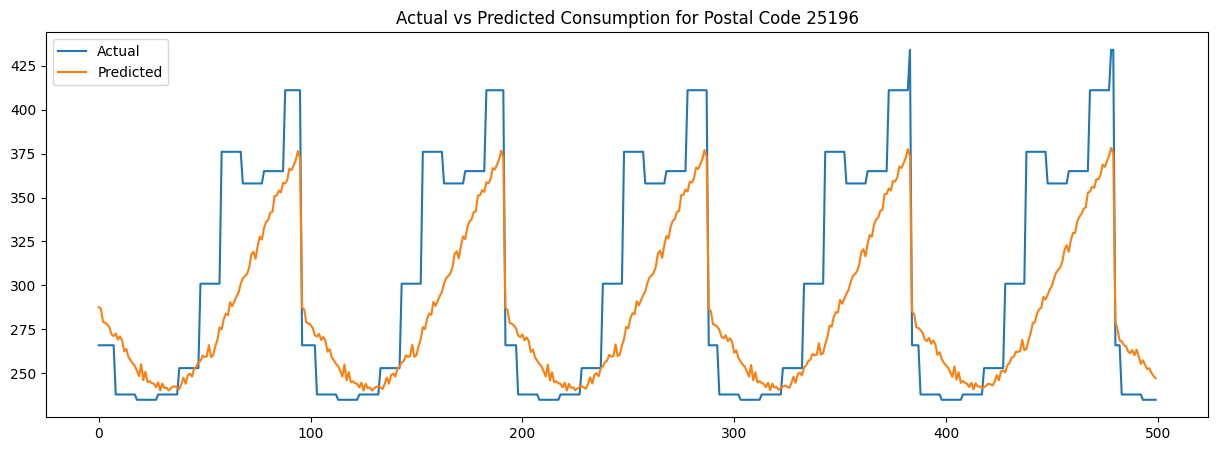

Processing postal code: 25197
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 3.1903 - mae: 0.7304 - val_loss: 2.9713 - val_mae: 0.8673 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 2.3485 - mae: 0.6941 - val_loss: 2.2894 - val_mae: 0.8041 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 1.7982 - mae: 0.6798 - val_loss: 1.8604 - val_mae: 0.7745 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 1.3868 - mae: 0.6461 - val_loss: 1.5833 - val_mae: 0.7663 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 1.1382 - mae: 0.6303 - val_loss: 1.4371 - val_mae: 0.7760 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.9537 - mae: 0.6156 - val_loss: 1.3020 - val_mae: 0.7595 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.8890 - mae: 0.6216 - val_loss: 1.2558 - val_mae: 0.7764 - learning_rate: 0.0010
Epoch 8/20
18/18 

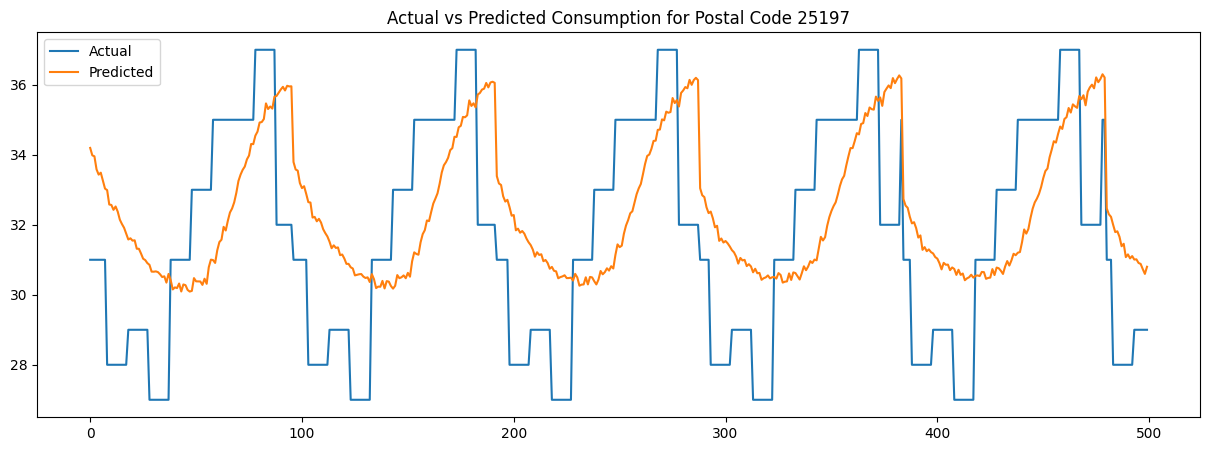

Processing postal code: 25198
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 3.1282 - mae: 0.7765 - val_loss: 2.6780 - val_mae: 0.8819 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 2.1909 - mae: 0.6460 - val_loss: 1.9365 - val_mae: 0.7289 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 1.4923 - mae: 0.4904 - val_loss: 1.4265 - val_mae: 0.5944 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - loss: 1.0487 - mae: 0.3825 - val_loss: 1.2860 - val_mae: 0.6243 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.7808 - mae: 0.3454 - val_loss: 1.0374 - val_mae: 0.6037 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.5903 - mae: 0.3139 - val_loss: 0.8964 - val_mae: 0.5908 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.4644 - mae: 0.3021 - val_loss: 0.8753 - val_mae: 0.6176 - learning_rate: 0.0010
Epoch 8/20
18/18 

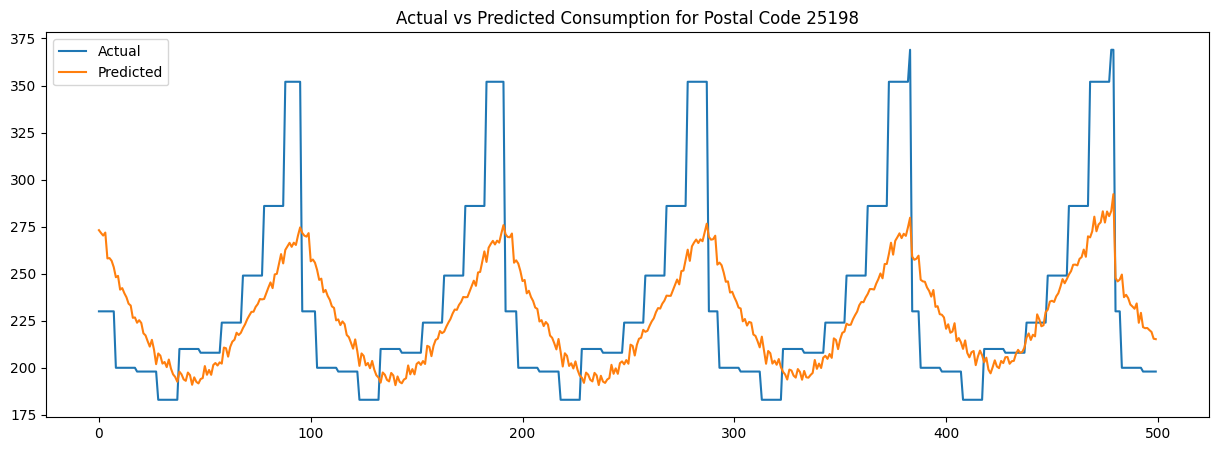

Processing postal code: 25199
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 3.0078 - mae: 0.7108 - val_loss: 2.6107 - val_mae: 0.8432 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 2.0698 - mae: 0.5701 - val_loss: 1.8369 - val_mae: 0.6893 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 1.4141 - mae: 0.4363 - val_loss: 1.2754 - val_mae: 0.5364 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.9936 - mae: 0.3513 - val_loss: 1.0646 - val_mae: 0.5526 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.7245 - mae: 0.3191 - val_loss: 0.8471 - val_mae: 0.5198 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.5739 - mae: 0.3311 - val_loss: 0.7744 - val_mae: 0.5459 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.4543 - mae: 0.3187 - val_loss: 0.6665 - val_mae: 0.5214 - learning_rate: 0.0010
Epoch 8/20
18/18 

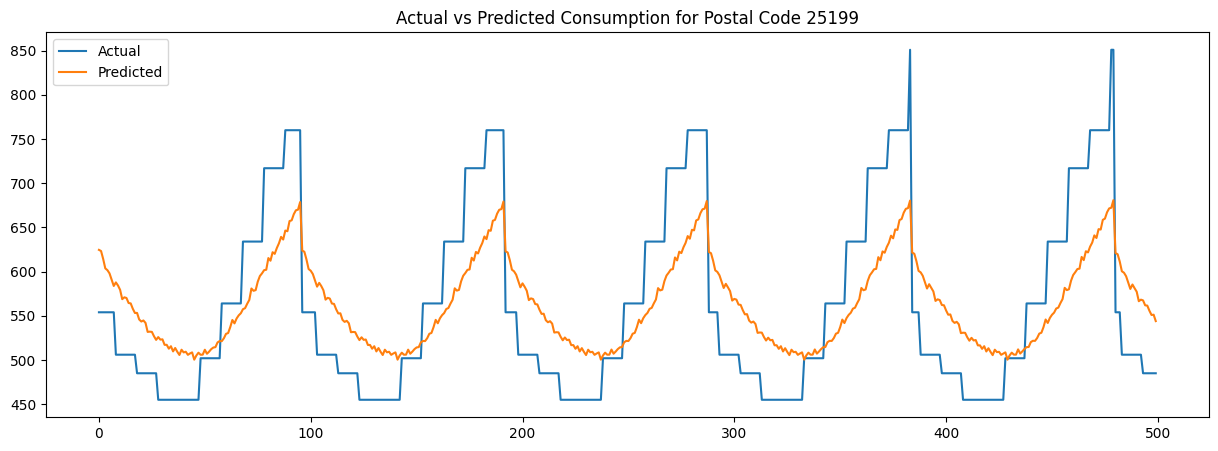

Processing postal code: 25190
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - loss: 3.3595 - mae: 0.8753 - val_loss: 2.0830 - val_mae: 0.4581 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 2.3213 - mae: 0.6930 - val_loss: 1.7466 - val_mae: 0.5827 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 1.6590 - mae: 0.5646 - val_loss: 1.3018 - val_mae: 0.5292 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 1.2313 - mae: 0.5075 - val_loss: 0.9994 - val_mae: 0.4896 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 0.9276 - mae: 0.4389 - val_loss: 0.9192 - val_mae: 0.5531 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7698 - mae: 0.4311 - val_loss: 0.6936 - val_mae: 0.4741 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.6118 - mae: 0.3876 - val_loss: 0.5949 - val_mae: 0.4546 - learning_rate: 0.0010
Epoch 8/20
18/18 

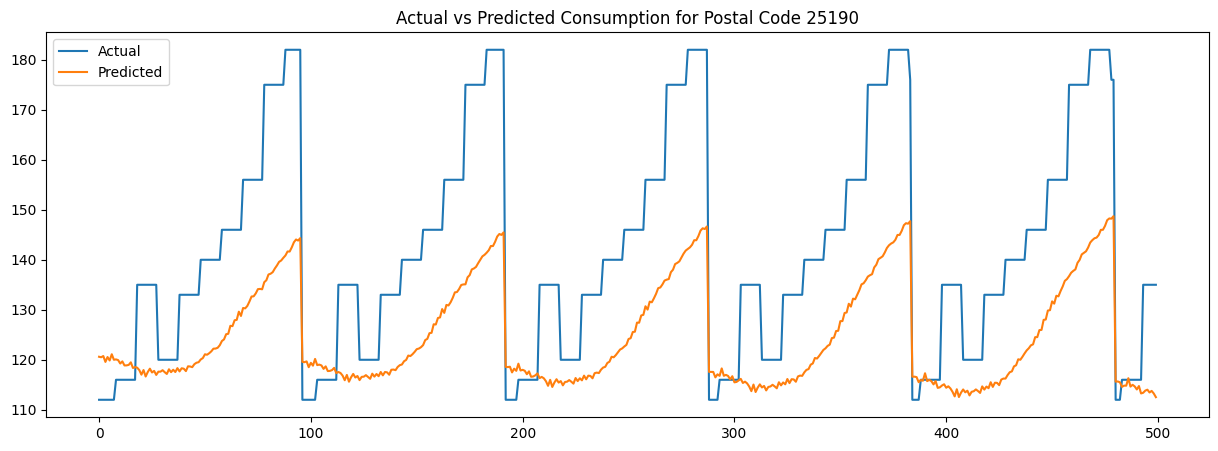

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Function to create sequences for time-series forecasting
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data) - 96):  # 96 steps for 96-hour forecast
        X.append(data[i - lookback:i, :-1])  # Exclude the target column
        y.append(data[i:i + 96, -1])  # Target column for next 96 hours
    return np.array(X), np.array(y)

# Define function to create LSTM model
def create_model(optimizer='adam', dropout_rate=0.2, lstm_units=64):
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(lookback, len(features))),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(96, kernel_regularizer=l2(0.01))  # 96-hour forecast
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

postal_codes = merged_data['postalcode'].unique()

# Parameters
lookback = 48
target = "consumption"
features = ['airtemperature', 'relativehumidity', 'windspeed', 'population']

# Manually define hyperparameters
manual_hyperparameters = {
    'optimizer': 'adam',
    'dropout_rate': 0.2,
    'lstm_units': 128,
    'batch_size': 32,
    'epochs': 20
}

# Iterate through each postal code
for code in postal_codes:
    print(f"Processing postal code: {code}")

    # Filter data for the postal code
    merged_data_new = merged_data[merged_data['postalcode'] == code].copy()
    data = merged_data_new[features + [target]].to_numpy()[:1000]  # Ensure data is numpy array

    # Normalize data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Create sequences
    X, y = create_sequences(data_scaled, lookback)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Create and compile model
    model = create_model(
        optimizer=manual_hyperparameters['optimizer'],
        dropout_rate=manual_hyperparameters['dropout_rate'],
        lstm_units=manual_hyperparameters['lstm_units']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Train the model
    history = model.fit(X_train, y_train, validation_split=0.2,
                        epochs=manual_hyperparameters['epochs'],
                        batch_size=manual_hyperparameters['batch_size'],
                        verbose=1,
                        callbacks=[early_stopping, lr_scheduler])

    # Evaluate model
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

    # Forecast
    y_pred = model.predict(X_test)

    # Rescale predictions and ground truth
    y_pred_rescaled = y_pred * scaler.scale_[-1] + scaler.mean_[-1]
    y_test_rescaled = y_test * scaler.scale_[-1] + scaler.mean_[-1]

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten()))
    mae = mean_absolute_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten())
    print(f"RMSE: {rmse}, MAE: {mae}")

    # Plot actual vs predicted
    plt.figure(figsize=(15, 5))
    plt.plot(y_test_rescaled.flatten()[:500], label="Actual")
    plt.plot(y_pred_rescaled.flatten()[:500], label="Predicted")
    plt.legend()
    plt.title(f"Actual vs Predicted Consumption for Postal Code {code}")
    plt.show()


In [6]:
!pip install scikeras